In [1]:
import requests
import folium
import urllib
from pandas.io.json import json_normalize
import pandas as pd
import folium
import geopandas as gpd
from shapely.geometry import Point
from pyproj import CRS, Transformer
import os
import pdal
import json
from ipywidgets import interact
from ipywidgets import widgets
import imageio
import pathlib
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np
import laspy
import rasterio
from rasterio import mask
from glob import glob
from shapely.geometry import box

In [5]:
def read_text(text_path):
    text = []
    with open(text_path) as fp:
        line = fp.readline()
        while line:
            line = line.rstrip("\n")
            text.append(line)
            line = fp.readline()
    return text

In [6]:
class Lidar():
    def __init__(self):
        self.text_path = 'filename.txt'
        self.PUBLIC_DATA = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/"
        self.output_file = 'spatial_subset.geojson'
        
    def region(self):
        self.output_slider_variable = widgets.Text()
                
        # Define function to bind value of the input to the output variable 
        def f(x):
            self.output_slider_variable.value = str(x)

        dropdown = interact(f, x=read_text(self.text_path))
        return self.output_slider_variable

    def ept_json(self):
        self.new_variable = str(self.output_slider_variable.value)
        self.PUBLIC_ACCESS_PATH = self.PUBLIC_DATA + self.new_variable + "ept.json"
        return self.PUBLIC_ACCESS_PATH
    
    def pipeline(self, xmin, xmax, ymin, ymax):
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
        xmin, ymax = transformer.transform(xmin, ymax)
        xmax, ymin = transformer.transform(xmax, ymin)
        self.pdal_aoi_bounds = f"([{xmin}, {xmax}], [{ymin}, {ymax}])"
        return self.pdal_aoi_bounds
        
    ## Define a function for running a pdal pipeline and returning the filename as output
    def run_pipeline(self):
        pipeline_def = self.pipeline_def = [
        {
            "bounds": self.pdal_aoi_bounds,
            "filename": self.PUBLIC_ACCESS_PATH,
            "type": "readers.ept",
            "tag": "readdata"
        },
        {
            "limits": "Classification![2:7], Classification![9:9]",
            "type": "filters.range",
            "tag": "nonoise"
        },
        {
            "filename": "spatial_subset.laz",
            "inputs": [ "nonoise" ],
            "tag": "writerslas",
            "type": "writers.las"
        },
       {
            "filename": "spatial_subset.tif",
            "gdalopts": "tiled=yes,     compress=deflate",
            "inputs": [ "writerslas" ],
            "nodata": -9999,
            "output_type": "idw",
            "resolution": 1,
            "type": "writers.gdal",
            "window_size": 6
        },
        {
        "type" : "writers.text",
        "format": "geojson",
        "write_header": True
        }
    ]
    
        output_file = self.output_file
        pipeline_def[-1]["filename"] = output_file
        pipeline_json =  json.dumps(pipeline_def)
        pipeline = pdal.Pipeline(pipeline_json)

        # remove the output file before building a new one
        if os.path.exists(output_file):
            os.remove(output_file)

        count = pipeline.execute()
        data = open(output_file, 'r').read()
        data = data.replace("[,{", "[{").replace("}{", "},{")
        open(output_file, 'w').write(data)
        return output_file

In [7]:
m=Lidar()

In [8]:
m.region()

interactive(children=(Dropdown(description='x', options=('AK_BrooksCamp_2012/', 'AK_Coastal_2009/', 'AK_Fairba…

Text(value='AK_BrooksCamp_2012/')

In [9]:
m.ept_json()

'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json'

In [10]:
m.pipeline(xmin = -93.756155,xmax = -93.747334, ymin = 41.918015, ymax = 41.921429)

'([-10436887.43333523, -10435905.484106943], [5148706.389047224, 5149217.145836504])'

In [11]:
m.run_pipeline()

'spatial_subset.geojson'

In [13]:
#geopandas df with geometry of xy
df = gpd.read_file('spatial_subset.geojson')
geometry = [Point(xy) for xy in zip(pd.to_numeric(df['X']), pd.to_numeric(df['Y']))]
gdf = gpd.GeoDataFrame(df, crs='epsg:4326',geometry=geometry)
gdf = gdf[["Z", "geometry"]]
gdf = gdf.rename(columns={"Z": "elevation_m", "geometry": "geometry"})
gdf.head()

,elevation_m,geometry
0,318.490,POINT (-10435906.070 5149216.030)
1,318.370,POINT (-10435907.330 5149215.640)
2,318.410,POINT (-10435908.700 5149215.960)
3,318.150,POINT (-10435921.570 5149216.780)
4,318.290,POINT (-10435920.250 5149216.480)


In [14]:
## Plot raster/tif image
# --------------------
def plot_raster(rast_data, title=''):
    """
    Plots raster tif image both in log scale(+1) and original verion
    """
    fig, (axlog, axorg) = plt.subplots(1, 2, figsize=(14,7))
    im1 = axlog.imshow(np.log1p(rast_data)) # vmin=0, vmax=2.1)
#     im2 = axorg.imshow(rast_data)

    plt.title("{}".format(title), fontdict = {'fontsize': 15})  
    plt.axis('off')
    plt.colorbar(im1, fraction=0.03)

In [15]:
# Read raster/tif file
# --------------------
spatial_subset_tif = 'spatial_subset.tif'
raster_subset = rasterio.open(spatial_subset_tif)
iowa_data = raster_subset.read(1)

In [16]:
count = iowa_data[iowa_data > 0].sum()
count

158639958.08695626

/tmp/ipykernel_23761/2443660254.py:13: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im1, fraction=0.03)


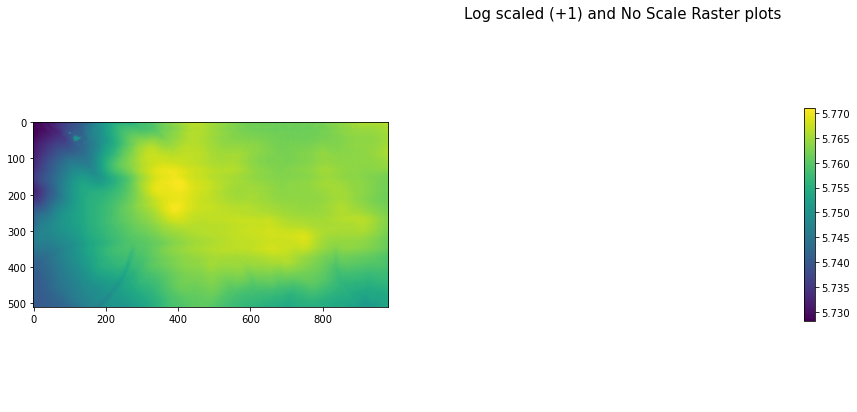

In [18]:
title = 'Log scaled (+1) and No Scale Raster plots'.format(count)
plot_raster(iowa_data, title)

In [19]:
# get shp from tif
from glob import glob
def get_shp_from_tif(tif_path:str, shp_file_path:str) -> None:
    raster = rasterio.open(tif_path)
    bounds = raster.bounds

    df = gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds)]})
   
    # save to file
    df.to_file(shp_file_path)
    print('Saved..')

In [20]:
get_shp_from_tif('spatial_subset.tif', shp_file_path='combi.shp')

Saved..
